### IMPORTS

In [1]:
from Inference.VariationalAE import MeanFieldVariationalAE


In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [5]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

# Load data #

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [7]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)




# Model principal

In [8]:
model = nn.Sequential( nn.Linear(1,20),
                       nn.Tanh(),               
                       nn.Linear(20,1),
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [9]:
param_count = get_param(model).shape[0]
param_count

61

In [10]:
flip_parameters_to_tensors(model)

# Modèle génératif: Hypernet autoencodeur

In [11]:
#choisir la dimension pour les paramètres latents
# lat_dim=5 donne des résultats intéressants!
lat_dim=5

In [12]:
# initialise 
# – (encodeur) une gaussienne diagonale N(0,I): mfvar (prior sur les variables latentes)
# – (decodeur) un NN avec 1 layer param_count neurones, activtion nn.Tanh()/nn.ReLU(): decoder
# forward(n): échantilloner theta=mfvar.decoder(mfvar.sample(n))
VAE = MeanFieldVariationalAE(lat_dim,param_count,param_count,nn.Tanh())
print('nb de paramètres VAE:'+str(get_param(VAE).shape[0]))
VAE


nb de paramètres VAE:4158


MeanFieldVariationalAE(
  (mfvar): MeanFieldVariationalDistribution()
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=61, bias=True)
    (1): Tanh()
    (2): Linear(in_features=61, out_features=61, bias=True)
  )
)

In [16]:
#prior sur les paramètres lambda du decodeur
# normale centrée à 0. d'écart-type sigma_prior à ajuster pour obtenir un a priori raisonnable sur les fonctions
sigma_prior=.01
mean_prior=0.
def prior_hyperWeights(w):
    return torch.nn.init.normal_(w, mean=mean_prior, std=sigma_prior)

def prior_hyperBias(w):
#    return torch.nn.init.normal_(w, mean=0.01, std=0.01)
    return torch.nn.init.uniform_(w, a=-.3, b=.3)

In [17]:
#initialise les paramètres lambda du decoder
def init_weights(m):
    if type(m) == nn.Linear:
        prior_hyperWeights(m.weight)
        prior_hyperBias(m.weight)

VAE.decoder.apply(init_weights)

Sequential(
  (0): Linear(in_features=5, out_features=61, bias=True)
  (1): Tanh()
  (2): Linear(in_features=61, out_features=61, bias=True)
)

# Plot prior #

le prior sur les paramètres $\theta$ du modèle principal est déterminé par le prior N(0,I) sur les variables latentes et par le l'initialisation du decodeur. C'est l'état du VAE avant entraînement. 

<IPython.core.display.Javascript object>


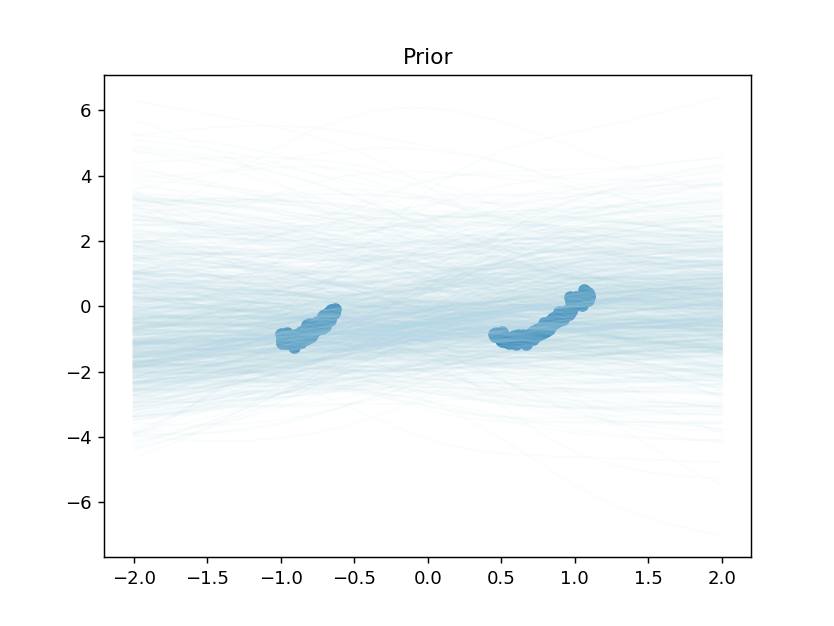

In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
import math

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.title('Prior')

plt.scatter(x_data.cpu(), y_data.cpu())
#plt.plot(x_test.detach().cpu().numpy(),torch.cos((4*x_test)+0.8).cpu().numpy(),color='red')
for i in range(1000):
#    z = prior.sample()
#    theta=VAE.decoder(z)
    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)
    
#    plt.axis('scaled')
#    plt.xlim(-0.2, 0.7) 
#    plt.ylim(-4,4) 
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')


# likelihood sur les paramètres latents #

In [19]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [20]:
# température :-)
sigma_like=.01 

# le likelihood d'un paramètre latent z étant donnée data est obtenu:
# 1. en décodant z: theta=decoder(z)
# 2. en utilisant theta comme paramètres du modèle principal
# 3. point estimate, pour chaque donnée (x,y) avec normal N(y_pred,sigma_like)
# En d'autres mots, pour tout decoder_lambda avec paramètres lambda:  
#z is likely for a single data (x,y) if y_pred=M_{decoder_lambda(z)}(x) is close to y (with respect to scale sigma_like)

def loglikelihood(z, sigma=sigma_like):
    theta=VAE.decoder(z)
    set_all_parameters(model, theta)
    y_pred = model(x_data)
    L = _log_norm(y_pred, y_data, torch.tensor([sigma],device=device))
    return torch.sum(L).unsqueeze(-1)

# KL-divergence #

$$D_\text{KL}\left(\mathcal{N}\left((\mu_1, \ldots, \mu_k)^\mathsf{T}, \operatorname{diag} (\sigma_1^2, \ldots, \sigma_k^2)\right) \parallel \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)\right) = {1 \over 2} \sum_{i=1}^k (\sigma_i^2 + \mu_i^2 - \ln(\sigma_i^2) - 1).$$

In [21]:
# KL-divergence entre une normale diagonale N(mu,diag(sigma)) et N(0,I)
def KLDivGauss(mu,sigma):
    Div=sigma+mu**2-sigma.log()-1
    return 0.5*Div.sum().squeeze()

In [22]:
KLDivGauss(VAE.mfvar.mu.detach(),VAE.mfvar.sigma.detach())

tensor(0.)

# Training #

Il n'est pas possible de caluler la fonction de densité de notre distribution apprise sur les paramètres $\theta$ du modèle principal. Nous pouvons seulement échantilloner cette distribution via fonction forward de VAE, on échantillonne z selon VAE.mfvar.sample() puis on applique le decoder theta=VAE.decoder(z).

L'idée est donc de modéliser le posterior sur les VARIABLES LATENTES z (et non sur theta) selon la loi de Bayes:
$$
P(z|\text{data})=\frac{P(\text{data}|z)P(z)}{P(\text{data})}
$$
où le prior $P(z)$ est $N(0,I)$. Le logarithme du likelihood $P(\text{data}|z)$ est définit par la fontion log_likelihood(z,sigma) et dépend des paramètres $\lambda$ du decodeur. Notons $P(\text{data}|z)=P_\lambda(\text{data}|z)$ pour rendre explicite cette dépendance sur $\lambda$. On a 
$$\log P_\lambda(\text{data}|z)=\sum_{(x,y)} \log P(y |\text{Model}_{\text{decoder}_\lambda(z)}(x),\sigma_\text{like})$$
où $p(y |\text{Model}_{\text{decoder}_\lambda(z)}(x),\sigma_\text{like})$ est normale de moyenne $\text{Model}_{\text{decoder}_\lambda(z)}(x)$ est scale $\sigma_\text{like}$. À noter que l'évidence $P_\lambda(\text{data})=\int P_\lambda(\text{data}|z)P(z) dz$ dépend également des paramètres $\lambda$ du decoder.

La divergence entre une distribution $Q(z)$ est le postérieur est donnée pour tout $\lambda$ par:
$$
D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z|\text{data}) )=D_\text{KL}(Q(z)\mathbin{\Vert} P(z)) - E_{Q(z)}[\log P_\lambda(\text{data}|z)]+ \log(P_\lambda(\text{data})).
$$
Ainsi:
$$
\log P_\lambda(\text{data})= E_{Q(z)}[\log P_\lambda(\text{data}|z)]- D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z) )-D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z|\text{data})) \geq E_{Q(z)}[P_\lambda(\text{data}|z)]- D_\text{KL}(Q(z) \mathbin{\Vert} P(z) )
$$
puisque $D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z|\text{data}))\geq 0$ pour toute distirbution $Q$ et tout $\lambda$.

On minimise donc la fonction:
$$
-\text{ELBO}(\mu,\sigma,\lambda) = D_\text{KL}(Q(z) \mathbin{\Vert} P(z) )- E_{Q(z)}[\log P_\lambda(\text{data}|z)]
$$
où $Q(z)$ est normale diagonale $N(\mu, diag(\sigma))$ (c'est VAE.mfvar) et $log P_\lambda(\text{data}|z)$ dépend des paramètres $\lambda$ du decoder (VAE.decoder). Pour tout $\mu,\sigma, \lambda$ on a
$$
\log P_\lambda(\text{data})\geq \log P_\lambda(\text{data})-D_\text{KL}(Q_{\mu,\sigma}(z) \mathbin{\Vert} P_\lambda(z|\text{data}) )=\text{ELBO}(\mu,\sigma,\lambda)
$$

Si $D_\text{KL}(Q(z) \mathbin{\Vert} P(z))$ peut être calculée en dollars et ne dépend pas de $\lambda$, le terme $E_{Q(z)}[\log P_\lambda(\text{data}|z)]$ est estimé en échantillonant des $z_i$ (et donc des $\theta_i=\text{decoder}_\lambda(z_i)$) puis en faisant la moyenne des $\log P_\lambda(\text{data}|z_i)$.



In [23]:


n_samples_VAR = 100

In [36]:
VAE_optimizer = torch.optim.Adam(VAE.parameters(), lr=.0001)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=30, factor=0.5)


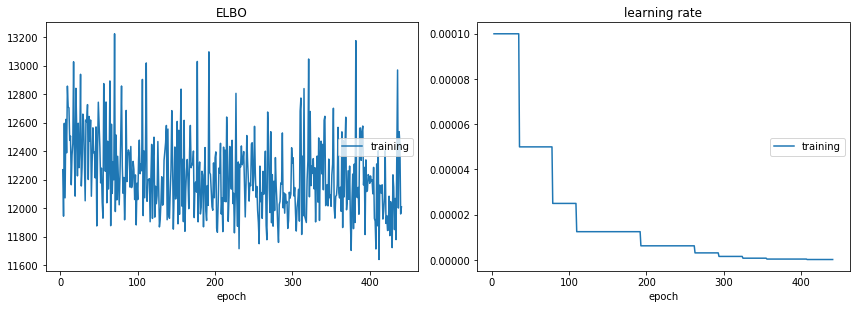

ELBO:
training   (min: 11639.777, max: 13223.338, cur: 12009.104)

learning rate:
training   (min:    0.000, max:    0.000, cur:    0.000)


In [37]:
%matplotlib inline

liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
    LL=torch.Tensor(n_samples_VAR)

    for i in range(n_samples_VAR):
        z = VAE.mfvar.sample()
        LL[i]=loglikelihood(z)

    L = Div - LL.mean()
    
    L.backward()
    

    learning_rate = VAE_optimizer.param_groups[0]['lr']

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    #if t %2 == 0:
    VAE_optimizer.step()

    if learning_rate < 0.0000001:
        break

# Résultats #

In [39]:
(VAE.mfvar.mu,VAE.mfvar.sigma)

(Parameter containing:
 tensor([ 0.1988,  0.0841, -0.2824,  0.3668, -0.4734], requires_grad=True),
 tensor([0.2331, 0.1888, 0.4814, 0.1740, 0.3716], grad_fn=<LogBackward>))

In [40]:
for layer in VAE.decoder.modules():
    if isinstance(layer, nn.Linear):
        print(layer.weight)

Parameter containing:
tensor([[ 3.8809e-02, -5.1033e-01, -5.0935e-02,  1.9358e-01, -1.5075e-01],
        [ 1.1223e-01, -4.7952e-01, -1.9569e-01,  2.7419e-01, -1.3192e-01],
        [ 2.0612e-01,  3.5633e-02, -1.6798e-01, -1.8758e-01,  7.5074e-02],
        [ 2.1638e-01,  1.6342e-01, -9.9660e-03,  1.3034e-01,  3.2069e-02],
        [-8.5069e-02, -1.8103e-01,  3.0361e-02,  6.2739e-02,  3.4459e-01],
        [ 2.5854e-01,  2.8674e-01,  9.1287e-02, -4.1398e-01, -3.6668e-01],
        [-4.8312e-01,  2.3510e-01,  4.2154e-02,  3.7880e-01, -1.3921e-01],
        [ 2.6761e-02,  2.0549e-01, -4.8669e-02,  4.3418e-02, -7.8420e-02],
        [ 7.8445e-02, -1.2752e-01, -1.6421e-01, -3.6496e-01, -1.4657e-02],
        [-2.3893e-01,  2.1320e-02,  2.7764e-01,  1.7370e-02, -2.9785e-01],
        [-1.8310e-03, -1.6889e-01,  2.3827e-01, -1.9930e-01,  1.6484e-01],
        [ 2.3467e-02,  2.4128e-02,  3.8004e-02,  2.5296e-01,  3.1874e-01],
        [ 2.7905e-01,  9.9969e-02, -2.0810e-02, -4.8724e-04, -2.9011e-01],
   

(5,2*param_count): -177.975

In [41]:

L = VAE(10000).detach().numpy()

<IPython.core.display.Javascript object>


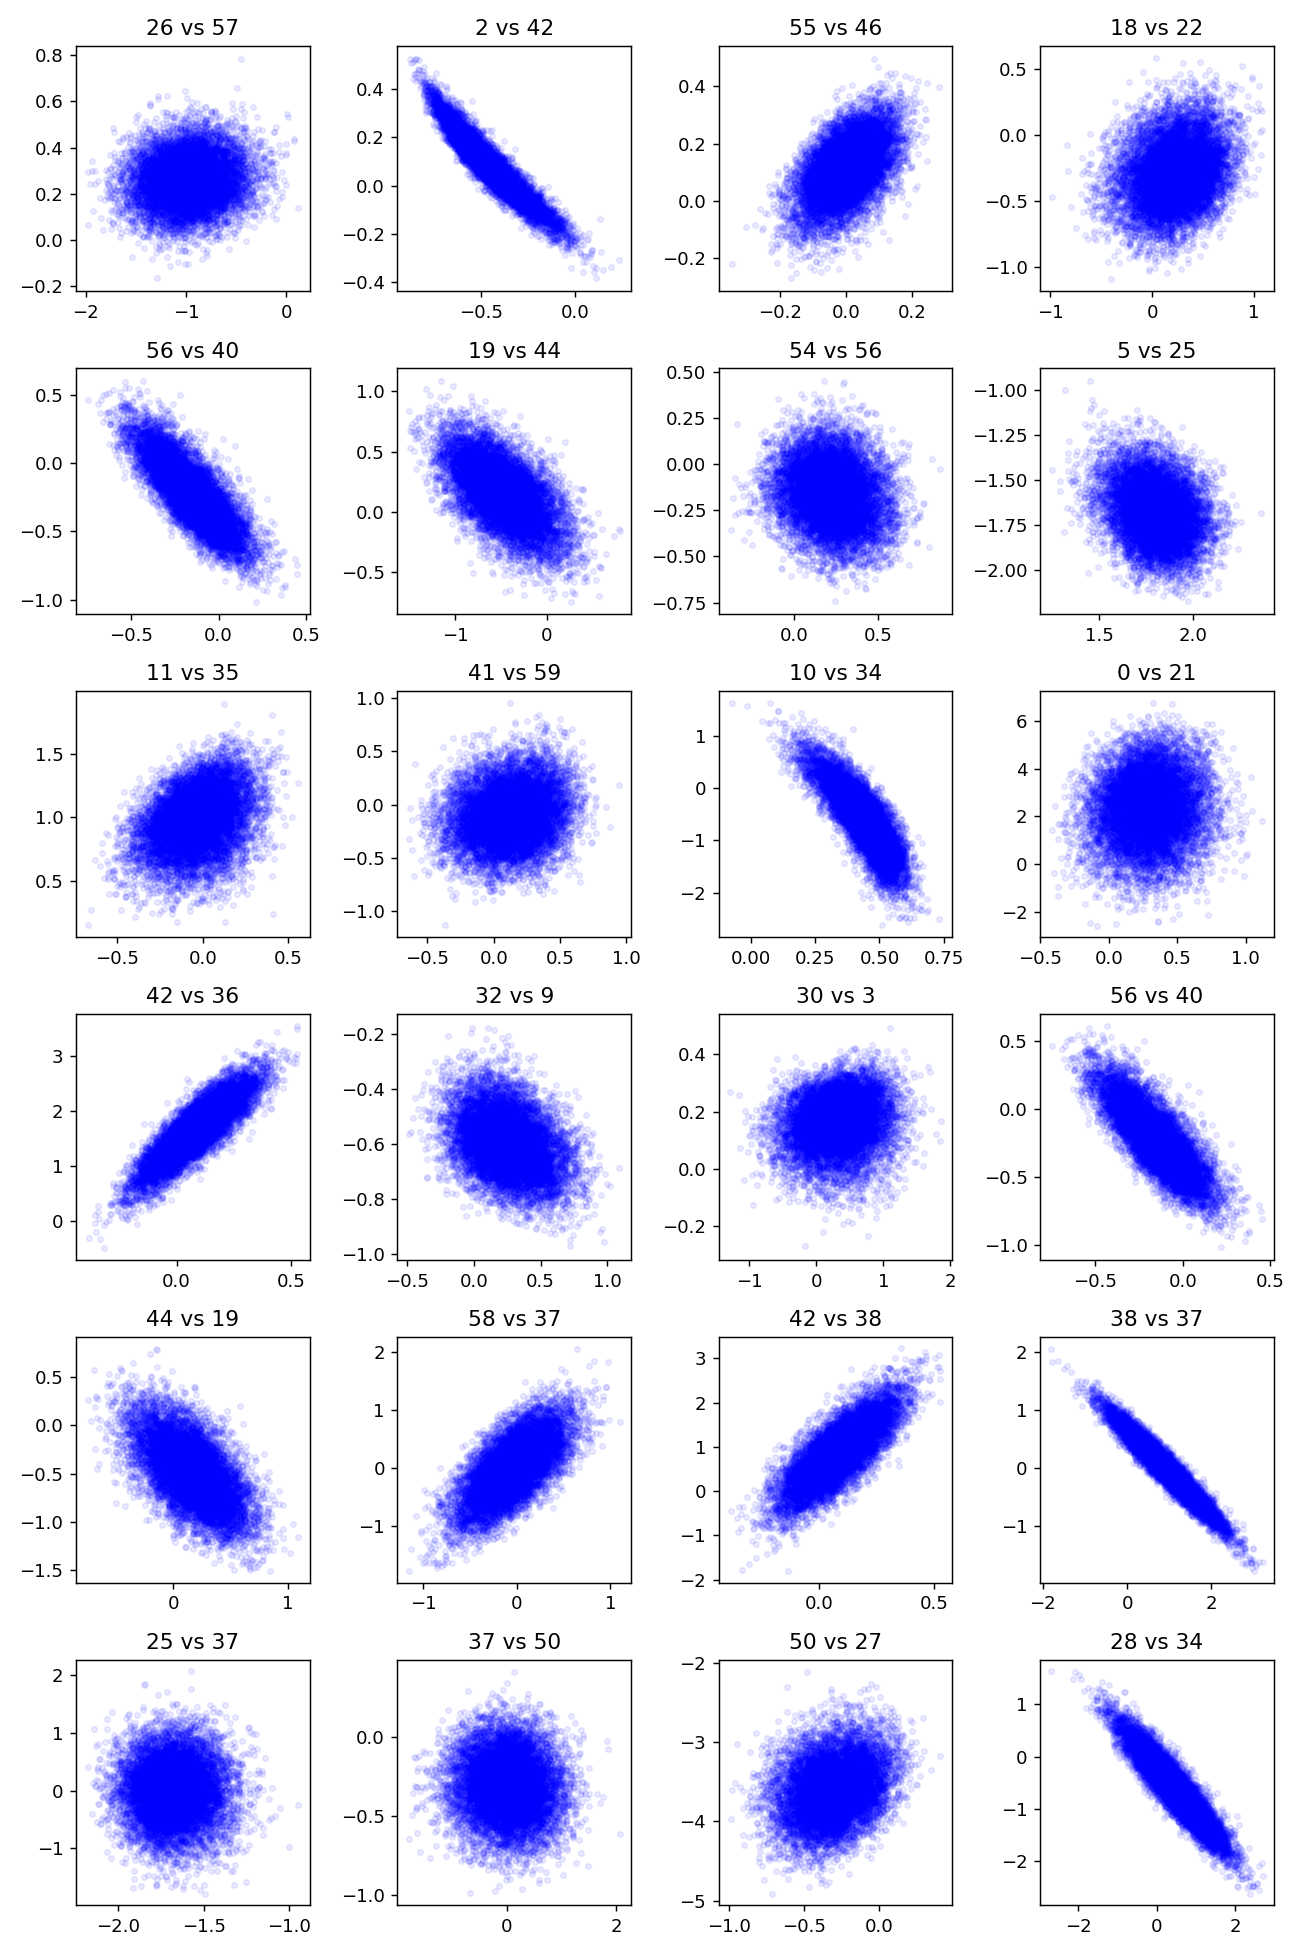

In [43]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, axs = plt.subplots(6, 4,figsize=(10,15))
for k in range(6):
    for l in range(4):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.08,color='blue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution ##


<IPython.core.display.Javascript object>


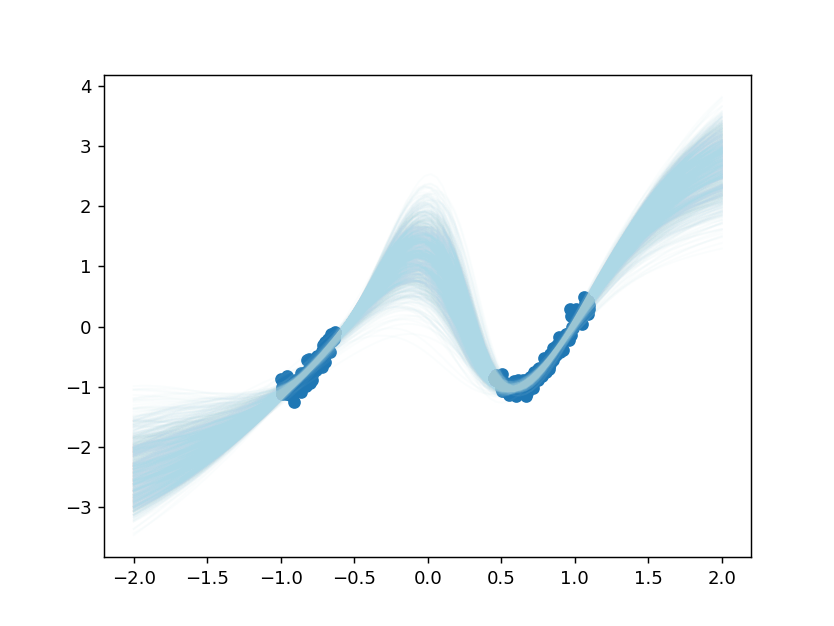

In [44]:
import matplotlib.pyplot as plt
%matplotlib notebook

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.scatter(x_data.cpu(), y_data.cpu())
for i in range(1000):
    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)    
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



In [ ]:
y_mean=y.mean(1)
y_std=y.std(1,True)
y_plus=y_mean+y_std
y_minus=y_mean-y_std
plt.plot(x_test.detach().cpu().numpy(),y_mean.squeeze(-1).detach().cpu().numpy(),linewidth=0.5, color='red', label='moyenne')
plt.plot(x_test.detach().cpu().numpy(),y_plus.squeeze(-1).detach().cpu().numpy(),linewidth=0.5, color='green',label='un écart-type')
plt.plot(x_test.detach().cpu().numpy(),y_minus.squeeze(-1).detach().cpu().numpy(),linewidth=0.5, color='green')
plt.legend()